In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, count, when, to_timestamp,to_date,skewness
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType, NumericType
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
from pyspark.sql.functions import year, month, dayofmonth, monotonically_increasing_id
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from xgboost.spark import SparkXGBRegressor


ModuleNotFoundError: No module named 'xgboost'

In [7]:
# file_path= 'DataCoSupplyChainDataset.csv'
file_path= '/content/drive/MyDrive/KALYAN/Acedamic_Projects/Bannu_Tasks/EDA/DataCoSupplyChainDataset.csv'

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SupplyChainOptimization').config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [9]:
# Calculating null counts for each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# To sort and transpose, additional steps are needed because PySpark does not directly support transposing:
# Convert the Row type into a dictionary, sort it, and then parallelize to create a new DataFrame
sorted_null_counts = sorted(null_counts.collect()[0].asDict().items(), key=lambda x: x[1], reverse=True)

# Create a new DataFrame from sorted values for transposition
new_df = spark.createDataFrame([sorted_null_counts], schema=["Column", "Count"])

# Since direct transposition isn't feasible in PySpark like in pandas, we handle the transpose manually
# Creating a DataFrame with one column per original column with their respective null count
transposed_df = spark.createDataFrame([(k, v) for k, v in sorted_null_counts], ['Column', 'Null Count'])

# Show the result
transposed_df.show()

+--------------------+----------+
|              Column|Null Count|
+--------------------+----------+
| Product Description|    180519|
|       Order Zipcode|    155679|
|      Customer Lname|         8|
|    Customer Zipcode|         3|
|                Type|         0|
|Days for shipping...|         0|
|Days for shipment...|         0|
|   Benefit per order|         0|
|  Sales per customer|         0|
|     Delivery Status|         0|
|  Late_delivery_risk|         0|
|         Category Id|         0|
|       Category Name|         0|
|       Customer City|         0|
|    Customer Country|         0|
|      Customer Email|         0|
|      Customer Fname|         0|
|         Customer Id|         0|
|   Customer Password|         0|
|    Customer Segment|         0|
+--------------------+----------+
only showing top 20 rows



In [10]:
# List of columns to be dropped
drop_cols = ['Product Description', 'Order Zipcode', "Product Image", "Customer Email", "Customer Fname",
             "Customer Lname", "Customer Password", "Customer Street"]

# Dropping the columns from the DataFrame
df = df.drop(*drop_cols)


In [11]:
# List of columns to be dropped
drop_cols = ['Market', 'Product Name', 'Order Id', 'Customer State',
             'Customer City', 'Customer Country', 'Customer Id', 'Order Region']

# Dropping the columns from the DataFrame
df = df.drop(*drop_cols)

In [12]:
date_cols = ['order date (DateOrders)', 'shipping date (DateOrders)']

# Convert date columns to timestamps
for col_name in date_cols:
    df = df.withColumn(col_name, to_timestamp(col_name, "MM/dd/yyyy HH:mm"))

# Show the DataFrame with converted timestamp columns
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+----------------+----------------+-------------+---------------+-----------+------------+----------+-------------+-----------------+-----------------------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------------+---------------+---------------+-------------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer Segment|Customer Zipcode|Department Id|Department Name|   Latitude|   Longitude|Order City|Order Country|Order Customer Id|order date (DateOrders)|Order Item Ca

In [13]:
# Get the schema of the DataFrame
schema = dict(df.dtypes)

# Separate numerical and categorical columns based on data type
numerical_cols = [k for k, v in schema.items() if v in ('int', 'double', 'float', 'bigint', 'long')]
categorical_cols = [k for k, v in schema.items() if v == 'string']

print("Numerical Features: ", numerical_cols)
print()
print("Categorical Features: ", categorical_cols)

Numerical Features:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Card Id', 'Product Category Id', 'Product Price', 'Product Status']

Categorical Features:  ['Type', 'Delivery Status', 'Category Name', 'Customer Segment', 'Department Name', 'Order City', 'Order Country', 'Order State', 'Order Status', 'Shipping Mode']


In [14]:
# Calculate skewness for each numerical column
skewness_df = df.select([skewness(col(c)).alias(c) for c in numerical_cols])

# Since skewness_df results in a single row DataFrame with each column representing skewness of the original columns,
# we need to convert this to a format that can be sorted (like turning it into a two-column DataFrame of column names and skewness values)
skew_list = [(c, skewness_df.collect()[0][c]) for c in numerical_cols]

# Convert list to DataFrame
skew_df = spark.createDataFrame(skew_list, ["Column", "Skewness"])

# Sort by skewness
sorted_skew_df = skew_df.orderBy("Skewness")

In [15]:
unique_counts = []

# Calculate unique counts for each categorical column
for col_name in categorical_cols:
    unique_count = df.agg(countDistinct(col(col_name)).alias("unique_count")).collect()[0]["unique_count"]
    unique_counts.append(Row(Column=col_name, Unique_Count=unique_count))

# Convert list to DataFrame
unique_df = spark.createDataFrame(unique_counts)
sorted_unique_df = unique_df.orderBy("Unique_Count")
sorted_unique_df.show()

+----------------+------------+
|          Column|Unique_Count|
+----------------+------------+
|Customer Segment|           3|
|   Shipping Mode|           4|
|            Type|           4|
| Delivery Status|           4|
|    Order Status|           9|
| Department Name|          11|
|   Category Name|          50|
|   Order Country|         164|
|     Order State|        1089|
|      Order City|        3597|
+----------------+------------+



In [16]:
df = df.dropna(subset=numerical_cols)

In [17]:
## RandomForestClassifier using predictions

In [19]:
# Define the feature and label columns & Assemble the feature vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")

# Transform the data
transformed_data = assembler.transform(df)

# Split the data into training and test sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

In [20]:
labelIndex = "Days for shipping (real)"
featuresIndex = "features"
predictionIndex = "prediction"

# Creating RandomForest model.
rf = RandomForestClassifier(labelCol=labelIndex, featuresCol=featuresIndex, predictionCol=predictionIndex)

# train the model
rfModel = rf.fit(train_data)

# make predictions
predictions = rfModel.transform(test_data)

# evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=labelIndex, predictionCol=predictionIndex)
accuracy = evaluator.evaluate(predictions)

In [21]:
predictions.select(labelIndex, predictionIndex).show(10)

+------------------------+----------+
|Days for shipping (real)|prediction|
+------------------------+----------+
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
+------------------------+----------+
only showing top 10 rows



In [22]:
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9353516179956615
Test Error = 0.06464838200433853


In [23]:
## DecisionTreeClassifier using predictions

In [65]:
labelIndex = "Days for shipping (real)"
featuresIndex = "features"
predictionIndex = "prediction"

# Creating DecisionTree model.
dt = DecisionTreeClassifier(labelCol=labelIndex, featuresCol=featuresIndex, predictionCol=predictionIndex)

# train the model
dtModel = dt.fit(train_data)

# make predictions
predictions = dtModel.transform(test_data)

# evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=labelIndex, predictionCol=predictionIndex)
accuracy = evaluator.evaluate(predictions)

In [66]:
predictions.select(labelIndex, predictionIndex).show(10)

+------------------------+----------+
|Days for shipping (real)|prediction|
+------------------------+----------+
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
+------------------------+----------+
only showing top 10 rows



In [67]:
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 1.0
Test Error = 0.0


In [1]:
## XBBoost using predictions

In [90]:
labelIndex = "Days for shipping (real)"
featuresIndex = "features"
predictionIndex = "prediction"

# Creating SparkXGBRegressor model.
xgb = SparkXGBRegressor(
  features_col=featuresIndex, label_col=labelIndex, num_workers=spark.sparkContext.defaultParallelism, max_depth=5, missing=0.0
)

# train the model
xgb_model = xgb.fit(train_data)

# make predictions
predictions = xgb_model.transform(test_data)

# evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=labelIndex, predictionCol=predictionIndex)

accuracy = evaluator.evaluate(predictions)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!


In [91]:
predictions.select(labelIndex, predictionIndex).show(10)

+------------------------+--------------------+
|Days for shipping (real)|          prediction|
+------------------------+--------------------+
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
+------------------------+--------------------+
only showing top 10 rows



In [92]:
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.0
Test Error = 1.0


In [ ]:
## XBBoost using predictions

In [93]:
labelIndex = "Days for shipping (real)"
featuresIndex = "features"
predictionIndex = "prediction"

# Creating SparkXGBRegressor model.
xgb = SparkXGBRegressor(
  features_col=featuresIndex, label_col=labelIndex, num_workers=spark.sparkContext.defaultParallelism, max_depth=5, missing=0.0
)

paramGrid = ParamGridBuilder()\
  .addGrid(xgb.max_depth, [2, 5])\
  .addGrid(xgb.n_estimators, [10, 100])\
  .build()

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=xgb.getLabelCol(),
                                predictionCol=xgb.getPredictionCol())

crossval = CrossValidator(estimator=xgb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

xgb_model = crossval.fit(train_data)

# make predictions
predictions = xgb_model.transform(test_data)

# evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=labelIndex, predictionCol=predictionIndex)

accuracy = evaluator.evaluate(predictions)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-Py

In [94]:
predictions.select(labelIndex, predictionIndex).show(10)

+------------------------+--------------------+
|Days for shipping (real)|          prediction|
+------------------------+--------------------+
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
|                       0|1.502102986705722...|
+------------------------+--------------------+
only showing top 10 rows



In [95]:
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.0
Test Error = 1.0


In [ ]:
# EDA

In [19]:
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")

# Transform the data
transformed_data = assembler.transform(df)

# Compute Pearson correlation matrix
pearson_corr = Correlation.corr(transformed_data, "features").head()[0]

# Convert to pandas DataFrame for visualization
import pandas as pd
pearson_corr_df = pd.DataFrame(pearson_corr.toArray(), columns=numerical_cols, index=numerical_cols)

In [20]:
# Convert to pandas DataFrame
pandas_df = df.select(numerical_cols).toPandas()

# Compute Spearman correlation using pandas
spearman_corr_df = pandas_df.corr(method='spearman')

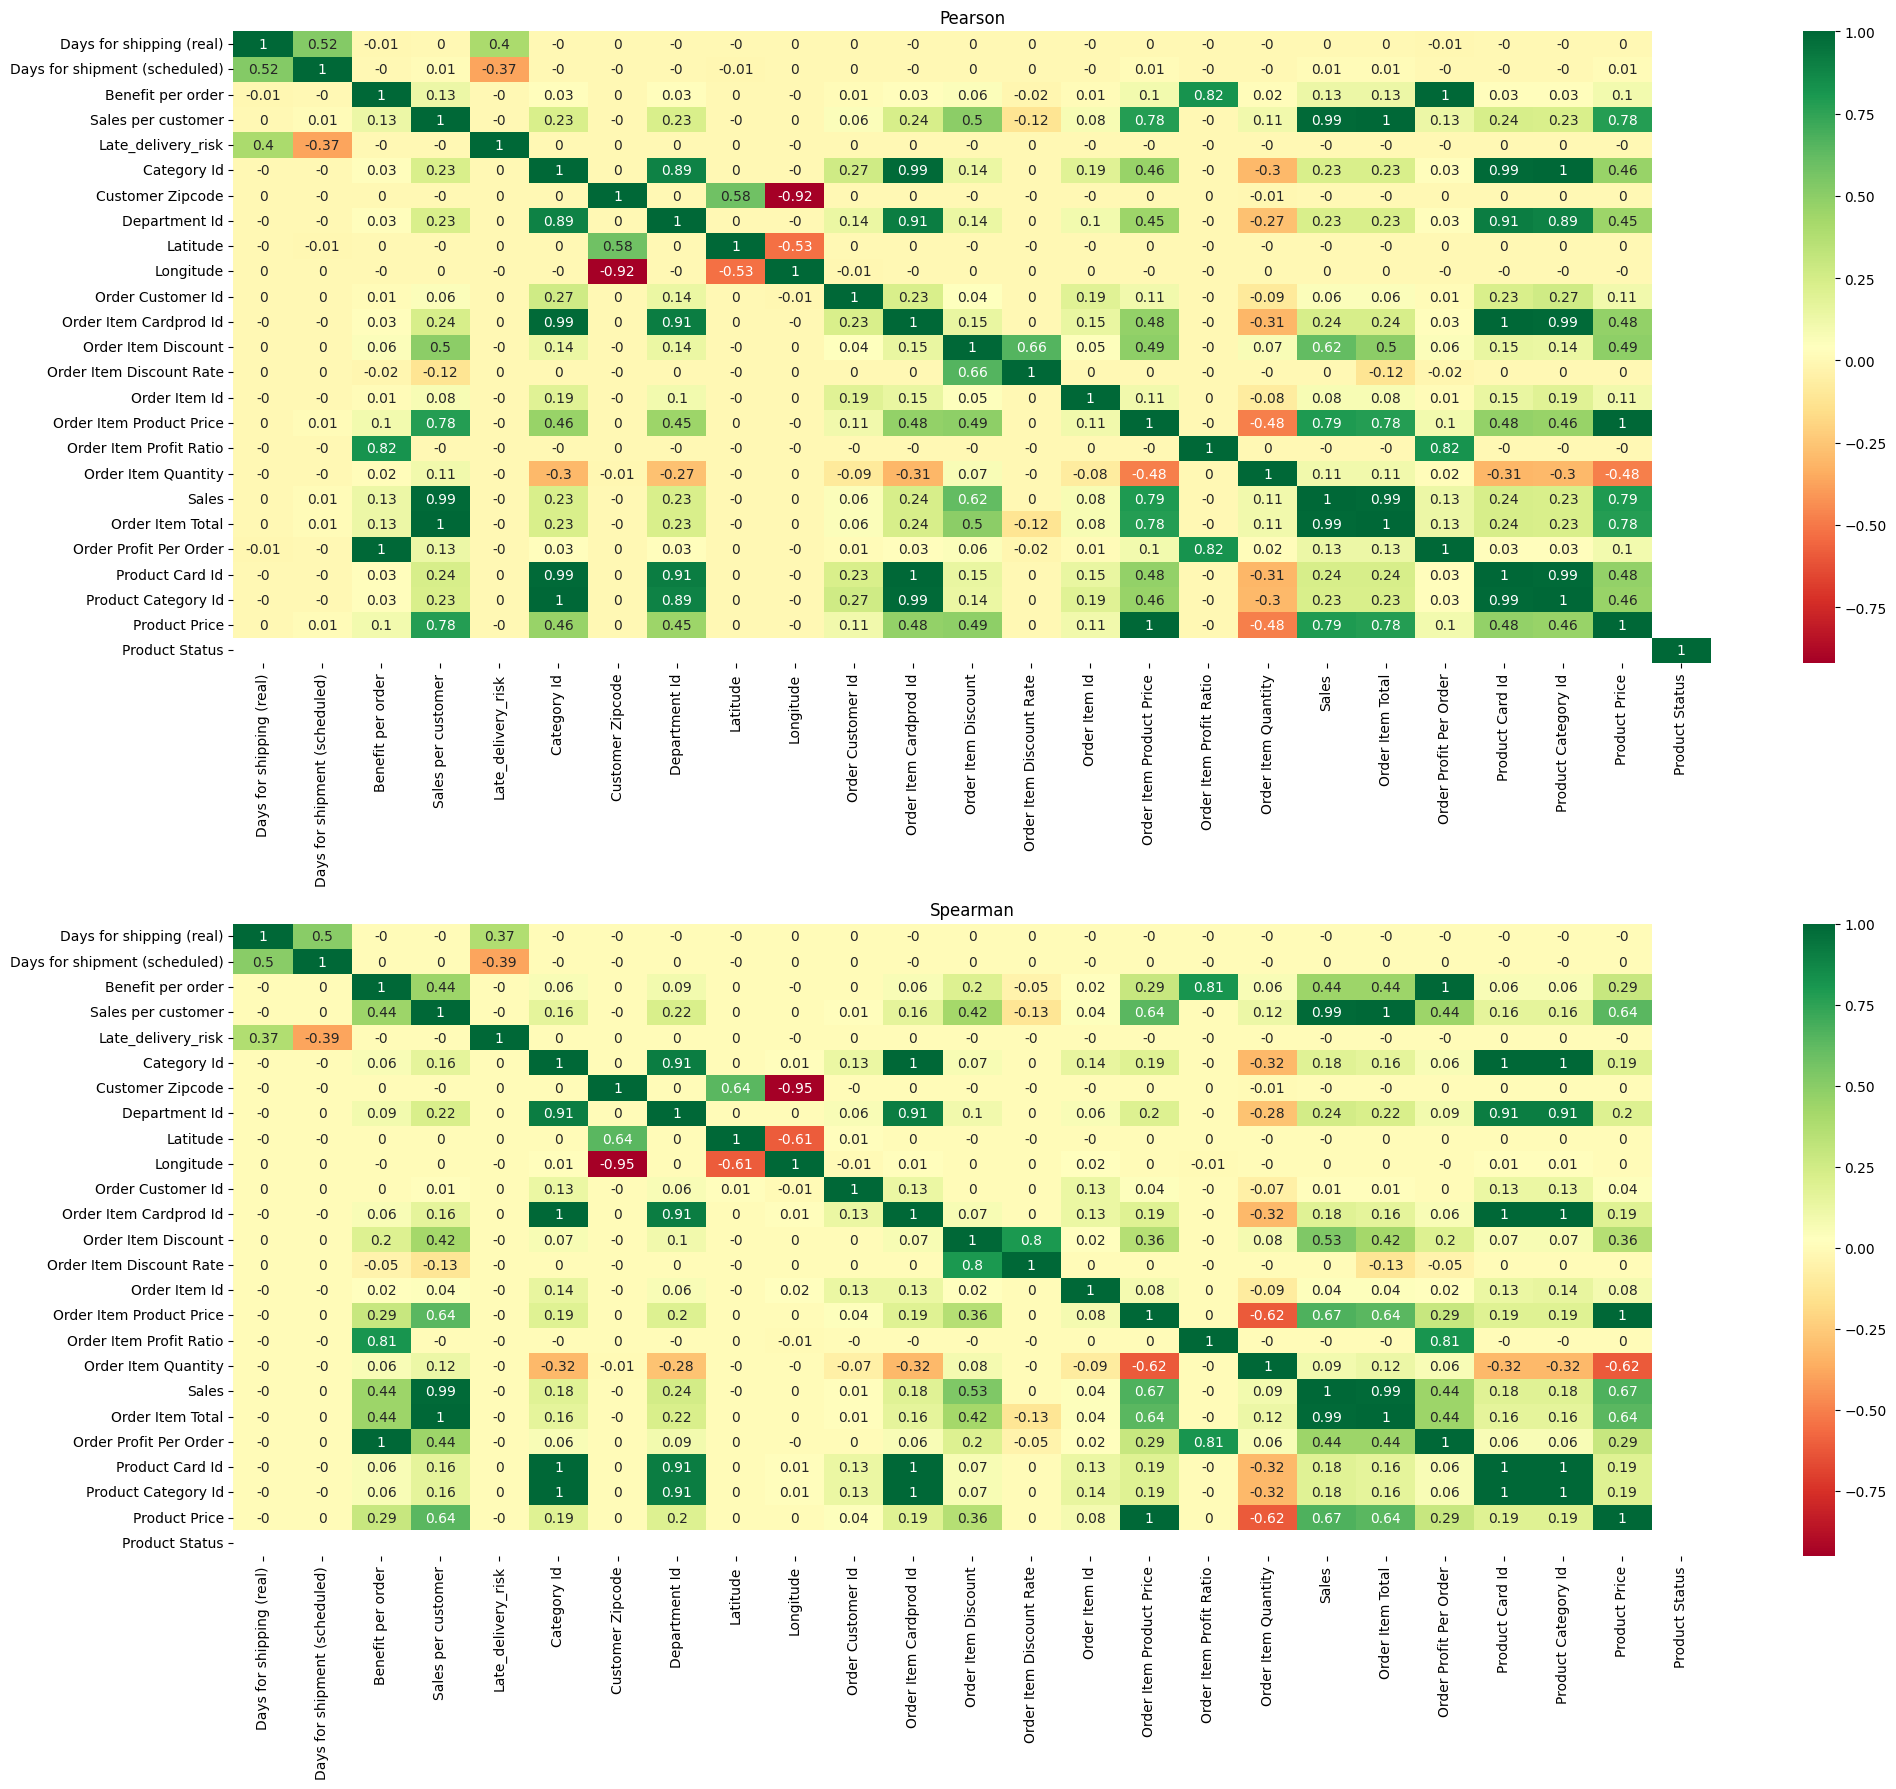

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(21, 18))

# Heatmap for Pearson correlations
sns.heatmap(pearson_corr_df.round(2), annot=True, ax=axes[0], cmap="RdYlGn")
axes[0].set_title('Pearson')

# Heatmap for Spearman correlations
sns.heatmap(spearman_corr_df.round(2), annot=True, ax=axes[1], cmap="RdYlGn")
axes[1].set_title('Spearman')

plt.tight_layout()
plt.show()

In [22]:
drop_cols = ['Order Profit Per Order', 'Sales per customer', 'Order Item Total', 'Department Id',
             'Order Item Cardprod Id', 'Product Category Id', 'Product Card Id', 'Order Customer Id',
             'Order Item Product Price', 'Product Status']
df = df.drop(*drop_cols)

In [23]:
# Get the schema of the DataFrame
schema = dict(df.dtypes)

# Separate numerical and categorical columns based on data type
numerical_cols = [k for k, v in schema.items() if v in ('int', 'double', 'float', 'bigint', 'long')]
categorical_cols = [k for k, v in schema.items() if v == 'string']

print("Numerical Features: ", numerical_cols)
print()
print("Categorical Features: ", categorical_cols)

Numerical Features:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Late_delivery_risk', 'Category Id', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Product Price']

Categorical Features:  ['Type', 'Delivery Status', 'Category Name', 'Customer Segment', 'Department Name', 'Order City', 'Order Country', 'Order State', 'Order Status', 'Shipping Mode']


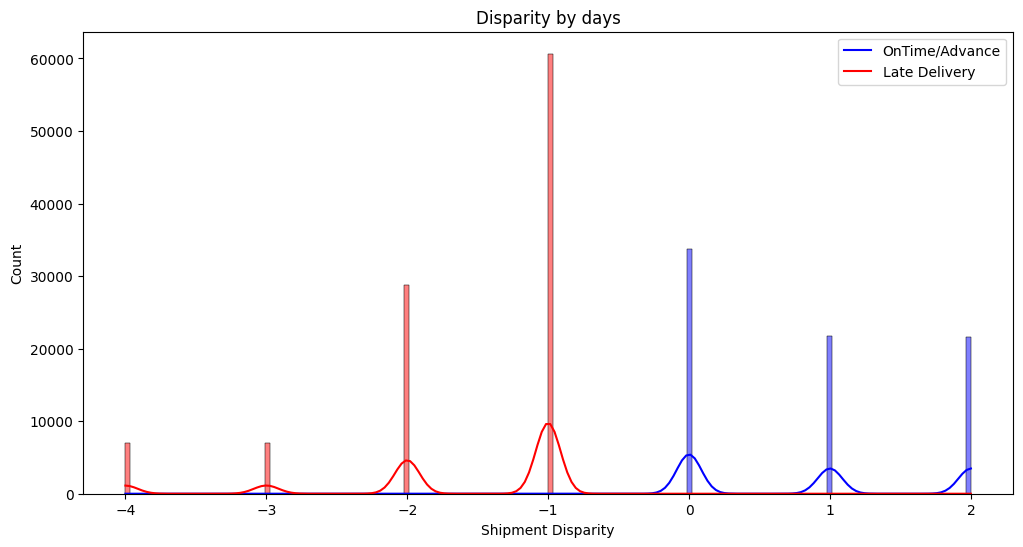

In [24]:
# Calculate 'Shipment Disparity'
df = df.withColumn('Shipment Disparity', col('Days for shipment (scheduled)') - col('Days for shipping (real)'))

# Convert the necessary column to pandas DataFrame for plotting
dd = df.select('Shipment Disparity').toPandas()

# Create a new column in pandas for the hue
dd['OnTime/Advance'] = dd['Shipment Disparity'] >= 0

# Plotting
plt.figure(figsize=(12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data=dd, x='Shipment Disparity', kde=True, hue='OnTime/Advance', palette=palette)
plot.legend(['OnTime/Advance', 'Late Delivery'])
plt.title('Disparity by days')
plt.show()

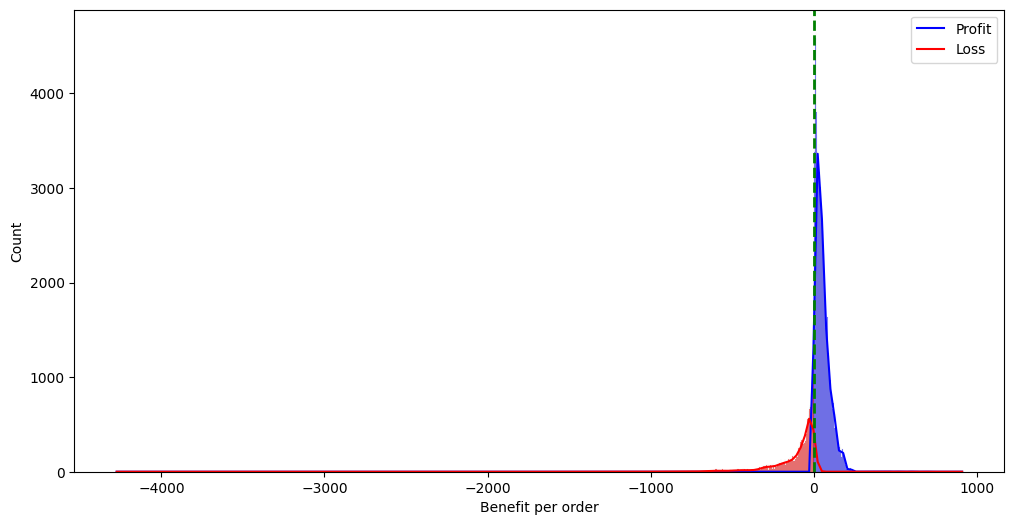

In [25]:
# Create a new column in PySpark for the hue
df = df.withColumn('Profit', col('Benefit per order') > 0)

# Convert the DataFrame to pandas for visualization
pdf = df.select('Benefit per order', 'Profit').toPandas()

# Plotting
plt.figure(figsize=(12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data=pdf, x='Benefit per order', kde=True, hue='Profit', palette=palette)
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plot.legend(['Profit', 'Loss'])
plt.show()

In [26]:
# Extract components from 'order date (DateOrders)'
df = df.withColumn('order_year', year('order date (DateOrders)'))
df = df.withColumn('order_month', month('order date (DateOrders)'))
df = df.withColumn('order_day', dayofmonth('order date (DateOrders)'))

# Extract components from 'shipping date (DateOrders)'
df = df.withColumn('shipping_year', year('shipping date (DateOrders)'))
df = df.withColumn('shipping_month', month('shipping date (DateOrders)'))
df = df.withColumn('shipping_day', dayofmonth('shipping date (DateOrders)'))

In [27]:
# Drop the columns
df = df.drop('order date (DateOrders)', 'shipping date (DateOrders)', 'Category Name')

# Display the first few rows of the DataFrame to verify the columns are dropped
df.show()

+--------+------------------------+-----------------------------+-----------------+-----------------+------------------+-----------+----------------+----------------+---------------+-----------+------------+----------+-------------+-------------------+------------------------+-------------+-----------------------+-------------------+------+--------------------+---------------+-------------+--------------+------------------+------+----------+-----------+---------+-------------+--------------+------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|  Delivery Status|Late_delivery_risk|Category Id|Customer Segment|Customer Zipcode|Department Name|   Latitude|   Longitude|Order City|Order Country|Order Item Discount|Order Item Discount Rate|Order Item Id|Order Item Profit Ratio|Order Item Quantity| Sales|         Order State|   Order Status|Product Price| Shipping Mode|Shipment Disparity|Profit|order_year|order_month|order_day|shipping_year|shipping_

In [28]:
# List categorical columns; this assumes all string columns are categorical
categorical_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
# Index and encode categorical columns
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

# Build and run the pipeline
pipeline = Pipeline(stages=indexers + encoders)
df = pipeline.fit(df).transform(df)

# Drop the original and intermediate columns
df = df.drop(*categorical_cols)
df = df.drop(*[c + "_indexed" for c in categorical_cols])

# Display the shape and the first few rows of the DataFrame
print("DataFrame shape: (rows: {}, columns: {})".format(df.count(), len(df.columns)))
df.show()

DataFrame shape: (rows: 180516, columns: 32)
+------------------------+-----------------------------+-----------------+------------------+-----------+----------------+-----------+------------+-------------------+------------------------+-------------+-----------------------+-------------------+------+-------------+------------------+------+----------+-----------+---------+-------------+--------------+------------+--------------------+-------------------------------+--------------------------------+-------------------------------+--------------------------+-----------------------------+---------------------------+----------------------------+-----------------------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Late_delivery_risk|Category Id|Customer Zipcode|   Latitude|   Longitude|Order Item Discount|Order Item Discount Rate|Order Item Id|Order Item Profit Ratio|Order Item Quantity| Sales|Product Price|Shipment Disparity|Profit|order_year|order_month|

In [29]:
# Split the DataFrame into X and y
X = df.drop('Days for shipping (real)', 'Days for shipment (scheduled)')
y = df.select('Days for shipping (real)', 'Days for shipment (scheduled)')

# Print the shapes
print("Shape of X: (rows: {}, columns: {})".format(X.count(), len(X.columns)))
print("Shape of y: (rows: {}, columns: {})".format(y.count(), len(y.columns)))

Shape of X: (rows: 180516, columns: 30)
Shape of y: (rows: 180516, columns: 2)


In [30]:
# Add a common index to join on
X = X.withColumn("index", monotonically_increasing_id())
y = y.withColumn("index", monotonically_increasing_id())

# Joining the dataframes
full_df = X.join(y, "index")

# Splitting the dataset
train_df, test_df = full_df.randomSplit([0.75, 0.25], seed=1234)

# Extracting training and testing sets
X_train = train_df.select([c for c in X.columns if c != 'index'])
X_test = test_df.select([c for c in X.columns if c != 'index'])
y_train = train_df.select([c for c in y.columns if c != 'index'])
y_test = test_df.select([c for c in y.columns if c != 'index'])

# Display first few rows to verify
X_train.show()
y_train.show()

+-----------------+------------------+-----------+----------------+-----------+------------+-------------------+------------------------+-------------+-----------------------+-------------------+------+-------------+------------------+------+----------+-----------+---------+-------------+--------------+------------+--------------------+-------------------------------+--------------------------------+-------------------------------+--------------------------+-----------------------------+---------------------------+----------------------------+-----------------------------+
|Benefit per order|Late_delivery_risk|Category Id|Customer Zipcode|   Latitude|   Longitude|Order Item Discount|Order Item Discount Rate|Order Item Id|Order Item Profit Ratio|Order Item Quantity| Sales|Product Price|Shipment Disparity|Profit|order_year|order_month|order_day|shipping_year|shipping_month|shipping_day|Type_indexed_encoded|Delivery Status_indexed_encoded|Customer Segment_indexed_encoded|Department Name_i